<a href="https://colab.research.google.com/github/mharoun20/DGE-PTB/blob/main/GEA_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Setup

In [ ]:
install.packages(c("Matrix","lattice","fdrtool","rpart"))

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.15")

BiocManager::install("affy")
BiocManager::install("GEOquery")
BiocManager::install("hgu133acdf")
BiocManager::install("limma")
BiocManager::install("gcrma")
BiocManager::install("Biobase")
BiocManager::install("BiocGenerics")
BiocManager::install("hgu133a.db", type = "source") 

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.18), R 4.2.1 (2022-06-23)

Installing package(s) 'BiocVersion'

Old packages: 'commonmark', 'cpp11', 'curl', 'devtools', 'evaluate', 'gert',
  'isoband', 'jsonlite', 'lifecycle', 'purrr', 'rmarkdown', 'roxygen2',
  'testthat', 'tibble', 'tidyselect', 'tidyverse', 'foreign', 'nlme'

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.18), R 4.2.1 (2022-06-23)

Installing package(s) 'affy'

also installing the dependencies ‘BiocGenerics’, ‘Biobase’, ‘affyio’, ‘preprocess

In [ ]:
library(Biobase)
library(BiocManager)
library(Matrix)
library(lattice)
library(fdrtool)
library(rpart)
library(affy)
library(Biobase)
library(GEOquery)
library(hgu133acdf)
library(limma)
library(gcrma)
library(hgu133a.db)
library(BiocGenerics)



Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)

Warning message:
“replacing previous import ‘AnnotationDbi::tail’ by ‘utils::tail’

### Data Extraction and Exploration




Data availability : https://www.ncbi.nlm.nih.gov/geo/-&nbsp;https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5999-&nbsp;https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM367784

Data Consideration:

*   we combine data from both these studies to identify differences in gene expression in PTB placentas compared to elective termination controls (Table 1). While it is impossible to know if the elective terminations would have resulted in preterm birth in the future, we posit that our controls still provide some validity, as we have selected them to match the gestational ages of the treatment groups at delivery, so differences in transcriptomic landscape attributed to gestational age should be well-controlled. Differences in transcriptomic landscape by gestational age have been identified in previous studies using the same type of samples (Winn et al., 2007).
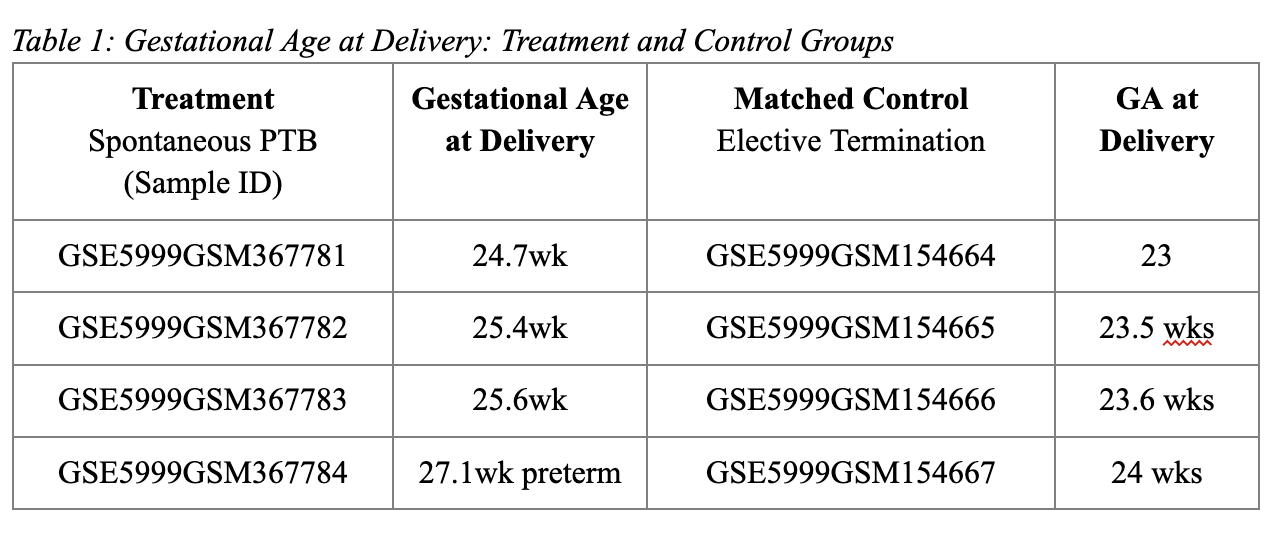




In [ ]:
celpath = '/content/sample_data' #change path to where you have the 6 cel files

In [ ]:
# import CEL files containing raw probe-level data into an R AffyBatch object 

data = ReadAffy(celfile.path=celpath)

In [ ]:
#retrive the raw expression levels (intensities) of the genes and look at the first few rows

expr = exprs(data)
expr[1:5,]

,ET 23 wks.cel,ET 23.5 wks.cel,ET 23.6 wks.cel,ET 24 wks.cel,PTB 24.7 wks.CEL,PTB 25.4 wks.CEL,PTB 25.6 wks.CEL,PTB 27.1 wks.CEL
1,86.0,808.0,123.5,89,125.0,107,62.0,168.0
2,7611.0,7785.0,8857.5,11852,14928.0,12038,4973.3,15478.0
3,118.5,198.0,107.0,95,135.5,119,72.0,185.5
4,7502.0,7894.5,8627.5,12266,15168.0,13524,5063.0,15962.0
5,49.0,70.0,72.0,47,55.0,53,49.5,69.0


In [ ]:
#retrive the samples' phenotypic annotations and store it in the dataframe ph
ph = data@phenoData
ph


An object of class 'AnnotatedDataFrame'
  sampleNames: ET 23 wks.cel ET 23.5 wks.cel ... PTB 27.1 wks.CEL (8
    total)
  varLabels: sample
  varMetadata: labelDescription

In [ ]:
#check if the samples have phenotypic annotations by exploring the data in the dataframe
ph@data

#apparently, there is no annotations (that is okay) 

,sample
,<int>
ET 23 wks.cel,1
ET 23.5 wks.cel,2
ET 23.6 wks.cel,3
ET 24 wks.cel,4
PTB 24.7 wks.CEL,5
PTB 25.4 wks.CEL,6
PTB 25.6 wks.CEL,7
PTB 27.1 wks.CEL,8


### Quality Assesment

In [ ]:
#Giving the samples informative names in the dataframe
ph@data[ ,1] = c("23wks_control","23.5wks_control","23.6wks_control","24wks_control", "24.7wks_treatment","25.4wks_treatment","25.6wks_treatmet","27.1wks_treatment")
ph@data

,sample
,<chr>
ET 23 wks.cel,23wks_control
ET 23.5 wks.cel,23.5wks_control
ET 23.6 wks.cel,23.6wks_control
ET 24 wks.cel,24wks_control
PTB 24.7 wks.CEL,24.7wks_treatment
PTB 25.4 wks.CEL,25.4wks_treatment
PTB 25.6 wks.CEL,25.6wks_treatmet
PTB 27.1 wks.CEL,27.1wks_treatment


In [ ]:
# microarray pictures: asess the quality of individual arrays (checking potential inconsistencies)

for (i in 1:8)
{
array_pictures = paste("image",i,".jpg",sep="")
jpeg(array_pictures)
image(data[,i],main=ph@data$sample[i])
dev.off()
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



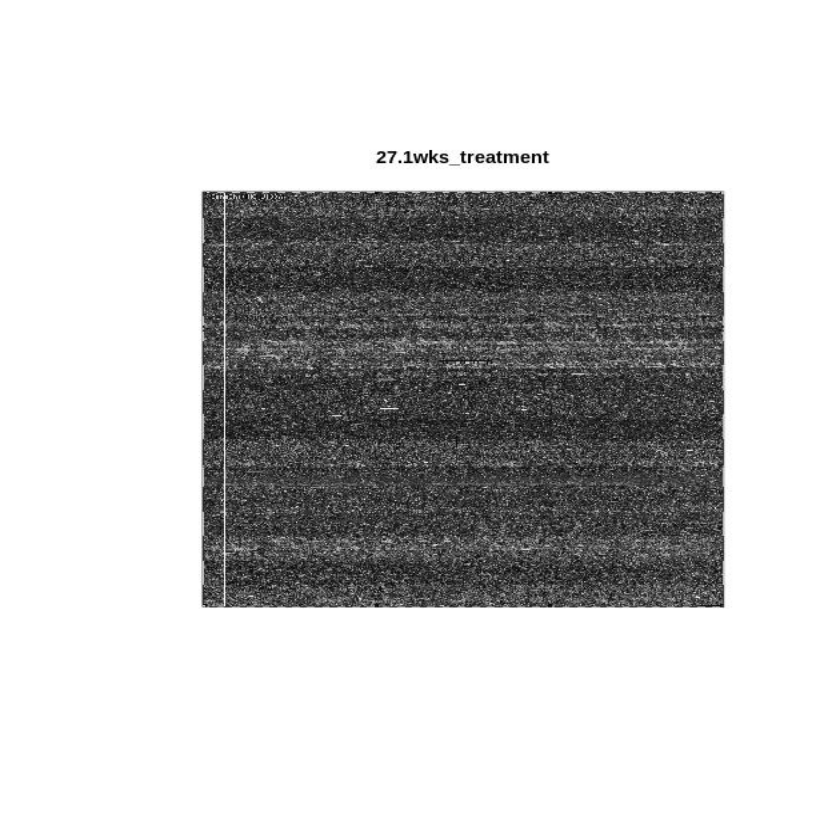

In [ ]:
#display microarray pictures
install.packages("jpeg")
library("jpeg")

jj <- readJPEG(array_pictures,native=TRUE)

plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
rasterImage(jj,0,0,1,1)

#pictures quality is too low for assessment

In [ ]:
# Intensity Distribution: see probe intensity behavior between different arrays. 
#If we see differences in shape or center of the distributions, it means that normalization is required.

for (i in 1:8)
{
Intensity_distribution = paste("histogram",i,".jpg",sep="")
jpeg(Intensity_distribution)
hist(data[,i],lwd=2,which='pm',ylab='Density',xlab='Log2 intensities',main=ph@data$sample[i])
dev.off()
}

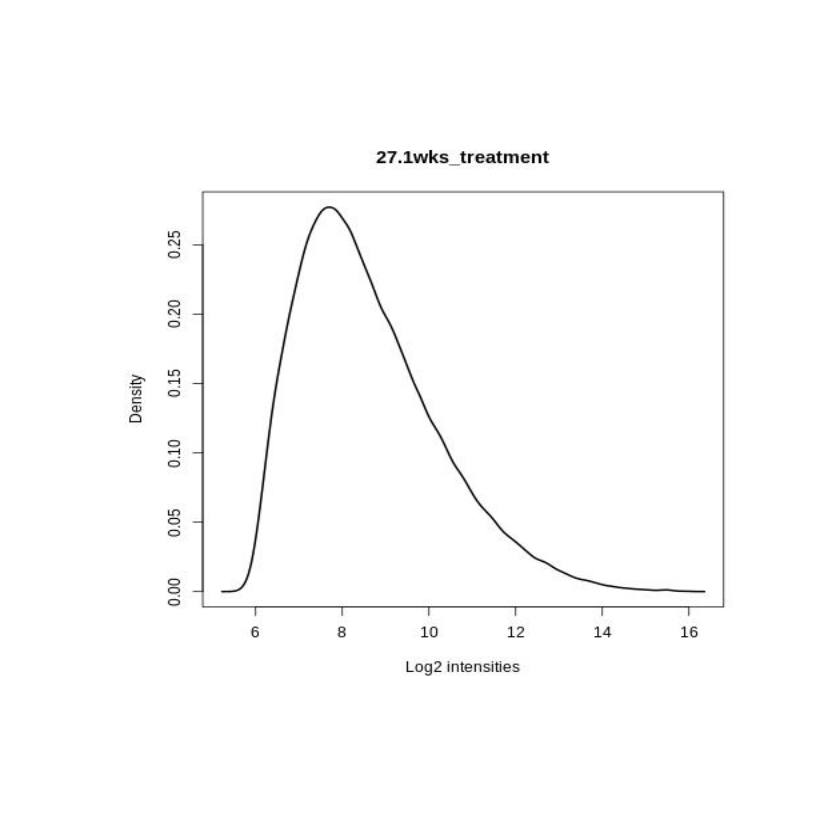

In [ ]:
#display intensity distributions
jj <- readJPEG(Intensity_distribution,native=TRUE)
plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
rasterImage(jj,0,0,1,1)

#histogram distribution seems different between samples (difference in skewness)

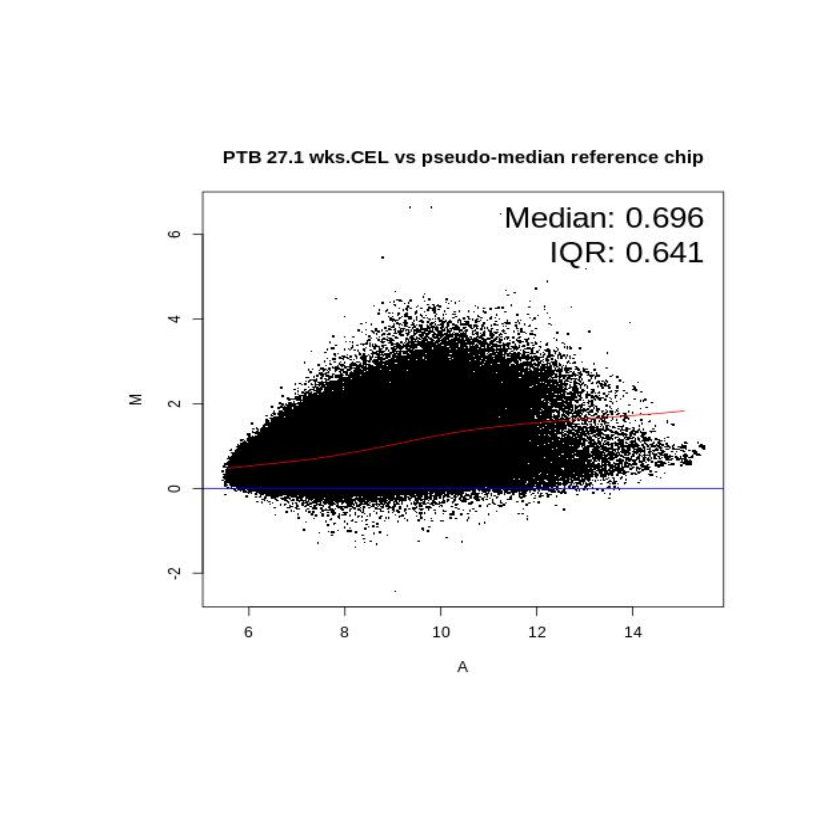

In [ ]:
#MA Plot: asses the extent the variability in expression with regard to  expression level 
#if more variation on high expression values, then we need normalization'

for (i in 1:8)
{
MA_plot = paste("MAplot",i,".jpg",sep="")
jpeg(MA_plot)
MAplot(data,which=i)
dev.off()
}
#display MA plots
jj <- readJPEG(MA_plot,native=TRUE)
plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
rasterImage(jj,0,0,1,1)

#variation is higher in high expression for most samples

**The different QA measures showed that normalization of the data is needed**


### Normalization

In [ ]:
#Normalization using RMA
data.normalized = rma(data)
data.matrix = exprs(data.normalized)


#save the data to an output file, data will be log2 transformed and normalized)
write.exprs(data.normalized,file="datanormalization.txt")

Background correcting
Normalizing
Calculating Expression


### Differential Gene Expression Analysis

In [ ]:
#step 1: tell limma which samples are control and which are treatment
#by adding a column with sample annotation we call "source" 
ph@data[ ,2] = c("control","control","control","control", "treatment","treatment","treatment","treatment")
colnames(ph@data)[2]="source"
ph@data

,sample,source
,<chr>,<chr>
ET 23 wks.cel,23wks_control,control
ET 23.5 wks.cel,23.5wks_control,control
ET 23.6 wks.cel,23.6wks_control,control
ET 24 wks.cel,24wks_control,control
PTB 24.7 wks.CEL,24.7wks_treatment,treatment
PTB 25.4 wks.CEL,25.4wks_treatment,treatment
PTB 25.6 wks.CEL,25.6wks_treatmet,treatment
PTB 27.1 wks.CEL,27.1wks_treatment,treatment


In [ ]:
#step 2: group the control samples together and the treatment samples together
groups = ph@data$source
f = factor(groups,levels=c("control","treatment"))
f

[1] control   control   control   control   treatment treatment treatment
[8] treatment
Levels: control treatment

In [ ]:
#step 3: create a design matrix, a matrix of values of the grouping variable, to run the ANOVA test by limma
design = model.matrix(~ 0 + f)
colnames(design) = c("control","treatment")

In [ ]:
#Step 4: calculate the mean expression levels using the lmFit() method
data.fit = lmFit(data.matrix,design)
data.fit$coefficients[1:10,]

#Step 5: tell limma which groups we want to compare by defining a contrast matrix defining the contrasts (comparisons) of interest by using the makeContrasts() method. 
contrast.matrix = makeContrasts(control-treatment,levels=design)
data.fit.con = contrasts.fit(data.fit,contrast.matrix)

,control,treatment
1007_s_at,9.734826,9.747211
1053_at,6.064103,6.227083
117_at,7.412175,7.570531
121_at,9.108141,9.188985
1255_g_at,4.352696,4.524198
1294_at,7.378420,7.128240
1316_at,5.698818,5.754806
1320_at,6.004825,6.203655
1405_i_at,5.724458,5.711856
1431_at,4.090200,4.153228


In [ ]:

#An empirical Bayes method is used to shrink the variance of each gene towards a common value for all the genes. This is to lower the influence of very low or very high standard deviations on the t-test. 
#Since the number of replicates is very low, the standard deviations will not be very reliable, ordinary t-statistics are not recommended.
data.fit.eb = eBayes(data.fit.con)
names(data.fit.eb)
data.fit.eb$coefficients[1:10,]

[1] "coefficients"     "rank"             "assign"           "qr"              
 [5] "df.residual"      "sigma"            "cov.coefficients" "stdev.unscaled"  
 [9] "pivot"            "Amean"            "method"           "design"          
[13] "contrasts"        "df.prior"         "s2.prior"         "var.prior"       
[17] "proportion"       "s2.post"          "t"                "df.total"        
[21] "p.value"          "lods"             "F"                "F.p.value"

1007_s_at     1053_at      117_at      121_at   1255_g_at     1294_at 
-0.01238420 -0.16297973 -0.15835601 -0.08084375 -0.17150258  0.25017975 
    1316_at     1320_at   1405_i_at     1431_at 
-0.05598778 -0.19882984  0.01260195 -0.06302860

png 
  2

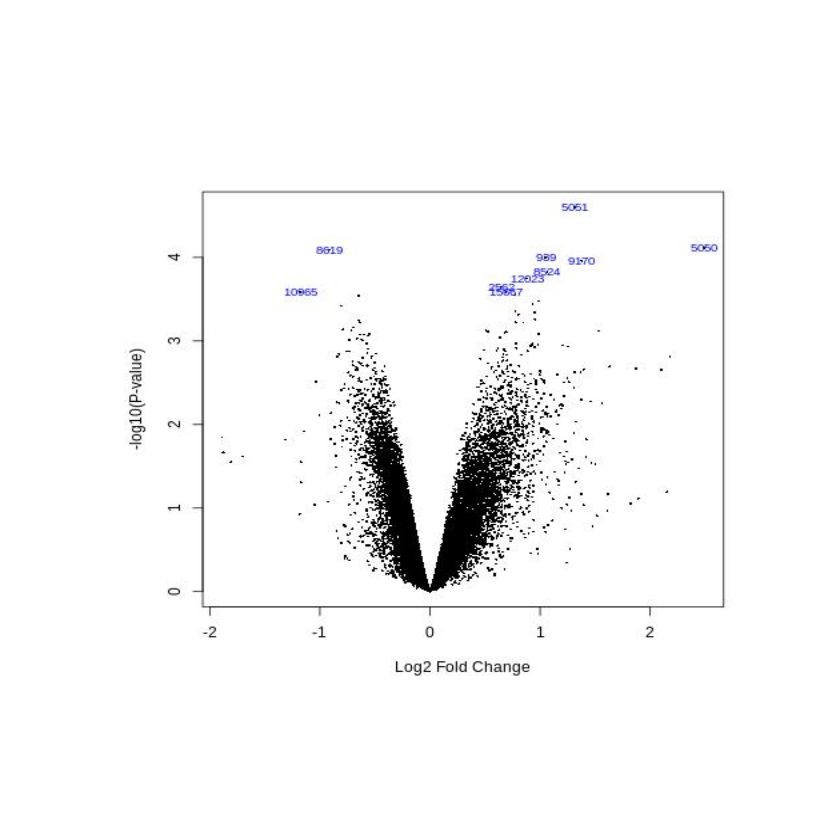

In [ ]:
#Create a volcano plot of gene expression
VP = paste("Volcano.jpg")
jpeg(VP)
volcanoplot(data.fit.eb,coef=1,highlight=10)
dev.off()

VPJ <- readJPEG(VP,native=TRUE)
plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
rasterImage(VPJ,0,0,1,1)

In [ ]:
#multiple testing
options(digits=2)
tab = topTable(data.fit.eb,coef=1,number=200,adjust.method="none")

In [ ]:
#create a subset of the table generated by topTable() with adjusted p-values below a threshold of 0.05
#distinguish between up- and downregulated genes and include a log fold change threshold

top_genes = tab[tab[, "adj.P.Val"] < 0.05, ]
topups = top_genes[top_genes[, "logFC"] > 1, ]
topdowns = top_genes[top_genes[, "logFC"] < -1, ]


In [ ]:
dim(top_genes)
dim(topups)
dim(topdowns)

[1] 200   6

[1] 26  6

[1] 2 6

In [ ]:
IDs.up = rownames(topups)
IDs.down = rownames(topdowns)

#save it
write.table(IDs.up,row.names=FALSE,col.names=FALSE,quote=FALSE,file="d:upIDs_test.txt")
write.table(IDs.down,row.names=FALSE,col.names=FALSE,quote=FALSE,file="d:downIDs_test.txt")